# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [101]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [102]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [103]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [59]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm=LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
      
        y_train_pred = svm.predict(X_train_feats)
        train_a=np.mean(y_train == y_train_pred)
      
        y_val_pred = svm.predict(X_val_feats)
        val_a  =np.mean(y_val == y_val_pred)
      
        results[(lr, reg)]=(train_a,val_a)
      
        if (val_a > best_val):
            best_val=val_a
            best_svm=svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 46.322609
iteration 100 / 1500: loss 45.941004
iteration 200 / 1500: loss 45.592066
iteration 300 / 1500: loss 45.229462
iteration 400 / 1500: loss 44.858406
iteration 500 / 1500: loss 44.497917
iteration 600 / 1500: loss 44.136660
iteration 700 / 1500: loss 43.802543
iteration 800 / 1500: loss 43.445255
iteration 900 / 1500: loss 43.103638
iteration 1000 / 1500: loss 42.771536
iteration 1100 / 1500: loss 42.434367
iteration 1200 / 1500: loss 42.098061
iteration 1300 / 1500: loss 41.781625
iteration 1400 / 1500: loss 41.450948
iteration 0 / 1500: loss 421.410838
iteration 100 / 1500: loss 382.148927
iteration 200 / 1500: loss 346.641068
iteration 300 / 1500: loss 314.489624
iteration 400 / 1500: loss 285.419526
iteration 500 / 1500: loss 259.101177
iteration 600 / 1500: loss 235.298275
iteration 700 / 1500: loss 213.765395
iteration 800 / 1500: loss 194.270524
iteration 900 / 1500: loss 176.637114
iteration 1000 / 1500: loss 160.679330
iteration 1100 / 1500: lo

In [60]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


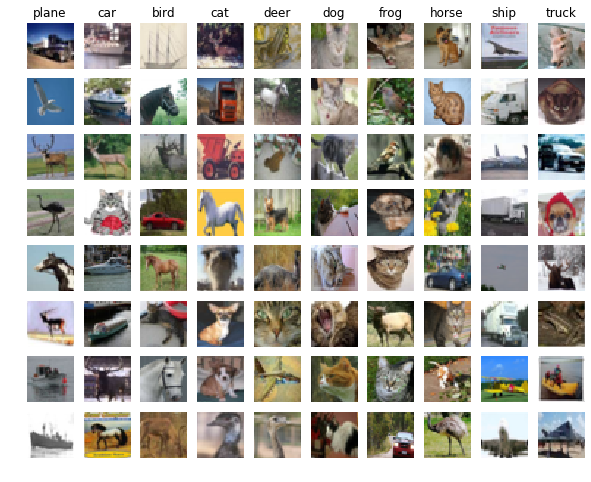

In [61]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Sort of. Seems like lots of color throw it off, that is, lots of blue predicts a plane, swathes of green predicts a frog, etc. Ship has a few other mechanical machines, maybe they look like machines, etc.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [62]:
print(X_train_feats.shape)

(49000, 155)


In [63]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = [1e-2 ,1e-1, 5e-1, 1, 5]
regularization_strengths = [1e-3, 5e-3, 1e-2, 1e-1, 0.5, 1]
best_net = None
best_acc = -1
results={}

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
       
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1500, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
        
                y_val_pred = net.predict(X_val_feats)
                val_acc = np.mean(y_val == y_val_pred)
                results[(lr,reg)] = val_acc
                #print(results[(lr,reg)])
                #print(net.best_val_acc)
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_net = net
                

for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]  
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.000000e-02 reg 1.000000e-03 val accuracy: 0.172000
lr 1.000000e-02 reg 5.000000e-03 val accuracy: 0.159000
lr 1.000000e-02 reg 1.000000e-02 val accuracy: 0.172000
lr 1.000000e-02 reg 1.000000e-01 val accuracy: 0.087000
lr 1.000000e-02 reg 5.000000e-01 val accuracy: 0.078000
lr 1.000000e-02 reg 1.000000e+00 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.524000
lr 1.000000e-01 reg 5.000000e-03 val accuracy: 0.523000
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.504000
lr 1.000000e-01 reg 1.000000e-01 val accuracy: 0.297000
lr 1.000000e-01 reg 5.000000e-01 val accuracy: 0.078000
lr 1.000000e-01 reg 1.000000e+00 val accuracy: 0.102000
lr 5.000000e-01 reg 1.000000e-03 val accuracy: 0.572000
lr 5.000000e-01 reg 5.000000e-03 val accuracy: 0.538000
lr 5.000000e-01 reg 1.000000e-02 val accuracy: 0.513000
lr 5.000000e-01 reg 1.000000e-01 val accuracy: 0.277000
lr 5.000000e-01 reg 5.000000e-01 val accuracy: 0.098000
lr 5.000000e-01 reg 1.000000e+00 val accuracy: 0

In [98]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.562


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [144]:
#For bonus,I change the opimization method,and use Adam for 2-layer NN.
#The method is in the "train" function
#And I make a comparison between the adam one and non-adam one.

In [145]:
#load data
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [151]:
from __future__ import print_function
from cs231n.classifiers.neural_net import TwoLayerNet

#the two layer Net with ADAM
class TwoLayerNet1(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################
    C=W2.shape[1]
    layer_1=np.dot(X,W1)+b1
    #reLu
    layer_1_relu=layer_1
    layer_1_relu[layer_1_relu<0]=0
    #output layer
    out_layer=np.dot(layer_1_relu,W2)+b2
    
    scores=out_layer
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss.                                                          #
    #############################################################################
    scores-=np.max(scores,axis=1,keepdims=True)
    
    p= np.exp(scores)/np.sum(np.exp(scores),axis=1,keepdims=True)
    
    
    y_map=np.zeros((N,C))
    y_map[np.arange(N),y]=1
  
    loss = -1 * np.sum(np.multiply(np.log(p),y_map)) / N
    loss += reg *(np.sum(W1 * W1)+np.sum(W2*W2)+np.sum(b1*b1)+np.sum(b2*b2))
                  
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    #############################################################################
    dscores=p
    dscores[range(N),y]-=1
    dscores/=N
    dW2=np.dot(layer_1_relu.T,dscores)
    db2=np.sum(dscores,axis=0,keepdims=False)
    
    dh1=np.dot(dscores,W2.T)
    
    #RELU layer
    dh1[layer_1_relu<=0]=0
    dW1=np.dot(X.T,dh1)
    db1=np.sum(dh1,axis=0,keepdims=False)
    
    #add regularization 
    dW2+=2*reg*W2
    dW1+=2*reg*W1
    
    #result
    grads['W1'] = dW1
    grads['b1'] = db1
    grads['W2'] = dW2
    grads['b2'] = db2              
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads


  def train(self, X, y, X_val, y_val,
            learning_rate=0.01, beta1=0.9,beta2=0.999,epsilon=1e-8,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False,t=0):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)
    
    loss_history = []
    train_acc_history = []
    val_acc_history = []


    #initialize adam
    L = 2 # number of layers in the neural networks
    v = {}
    s = {}
    t = t
    v_corrected = {}       # Initializing first moment estimate, python dictionary
    s_corrected = {}       # Initializing second moment estimate, python dictionary
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l + 1)] = np.zeros_like(self.params["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(self.params["b" + str(l + 1)])

        s["dW" + str(l+1)] = np.zeros_like(self.params["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(self.params["b" + str(l + 1)])
    
    
    for it in xrange(num_iters):
      t = t+1
      X_batch = None
      y_batch = None

     
      batch_index=np.random.choice(num_train,batch_size)
      X_batch=X[batch_index,:]
      y_batch=y[batch_index]
      

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)
      
      for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['W' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['b' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['W' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['b' + str(l + 1)], 2)
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
       
        # Update parameters.Output: "parameters".
        self.params["W" + str(l + 1)] = self.params["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        self.params["b" + str(l + 1)] = self.params["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
        
        
        
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)


    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None

    y_pred = np.argmax(self.loss(X),axis=1)
 
    return y_pred

iteration 0 / 1000: loss 2.302937
iteration 100 / 1000: loss 1.819489
iteration 200 / 1000: loss 1.752880
iteration 300 / 1000: loss 1.682450
iteration 400 / 1000: loss 1.645721
iteration 500 / 1000: loss 1.605544
iteration 600 / 1000: loss 1.655732
iteration 700 / 1000: loss 1.775095
iteration 800 / 1000: loss 1.547564
iteration 900 / 1000: loss 1.478002
lr 1.000000e-04 reg 2.500000e-01 train accuracy: 0.487633 val accuracy: 0.460000
iteration 0 / 1000: loss 2.302983
iteration 100 / 1000: loss 2.302687
iteration 200 / 1000: loss 2.299991
iteration 300 / 1000: loss 2.266180
iteration 400 / 1000: loss 2.199049
iteration 500 / 1000: loss 2.194595
iteration 600 / 1000: loss 2.107653
iteration 700 / 1000: loss 2.076652
iteration 800 / 1000: loss 2.004488
iteration 900 / 1000: loss 1.997105
lr 1.000000e-04 reg 2.500000e-01 train accuracy: 0.280041 val accuracy: 0.296000


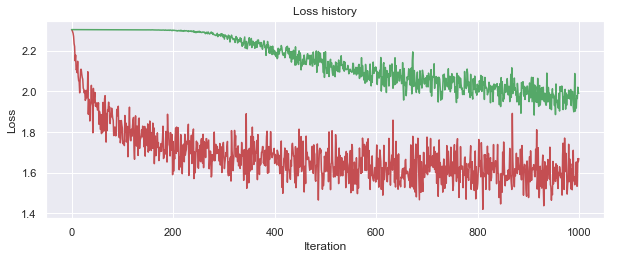

In [155]:
best_net1 = None # best model using ADAM
best_net2 = None # best model using the Assignment one 

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

results1 = {}
best_val1= -1
results2 = {}
best_val2= -1

# learning_rates = [1e-4]
# regularization_strengths = [0.25]

# params = [(x,y) for x in learning_rates for y in regularization_strengths ]

#the ADAM one
# for lrate, regular in params:
net1 = TwoLayerNet1(input_size, hidden_size, num_classes)
    # Train the network
stats1 = net1.train(X_train, y_train, X_val, y_val,
                      num_iters=1000, batch_size=200,
                      learning_rate=1e-4,
                      reg=0.25, verbose=True,t=0)

    # Predict on the validation set
accuracy_train1 = (net1.predict(X_train) == y_train).mean()
accuracy_val1 = (net1.predict(X_val) == y_val).mean()
#     results1[(lrate, regular)] = (accuracy_train1, accuracy_val1)
if( best_val1 < accuracy_val1 ):
    best_val1 = accuracy_val1
    best_net1 = net1
    best_stats1 = stats1

# Print out results.
# for lr, reg in sorted(results1):
#     train_accuracy, val_accuracy = results1[(lr, reg)]
print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                1e-4, 0.25, accuracy_train1,accuracy_val1 ))

# print ('best validation accuracy achieved during cross-validation: %f' % best_val1)


#the non-ADAM one
# for lrate, regular in params:
net2 = TwoLayerNet(input_size, hidden_size, num_classes)
    # Train the network
stats2 = net2.train(X_train, y_train, X_val, y_val,
                      num_iters=1000, batch_size=200,
                      learning_rate=1e-4,
                      reg=0.25, verbose=True)

    # Predict on the validation set
accuracy_train2 = (net2.predict(X_train) == y_train).mean()
accuracy_val2 = (net2.predict(X_val) == y_val).mean()
#     results2[(lrate, regular)] = (accuracy_train, accuracy_val)
if( best_val2 < accuracy_val2 ):
    best_val2 = accuracy_val2
    best_net2 = net2
    best_stats2 = stats2

# Print out results.
# for lr, reg in sorted(results2):
#     train_accuracy, val_accuracy = results2[(lr, reg)]
print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                1e-4, 0.25, accuracy_train2, accuracy_val2))

# print ('best validation accuracy achieved during cross-validation: %f' % best_val)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats1['loss_history'],label='ADAM',color='r')
plt.plot(best_stats2['loss_history'],label='non_ADAM',color='g')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# plt.subplot(2, 1, 2)
# plt.plot(best_stats['train_acc_history'], label='train',color='r')
# plt.plot(best_stats['val_acc_history'], label='val',color='g')
# plt.title('Classification accuracy history')
# plt.xlabel('Epoch')
# plt.ylabel('Clasification accuracy')
plt.show()

In [156]:
test_acc1 = (best_net1.predict(X_test) == y_test).mean()
print('Test accuracy1: ', test_acc1)

Test accuracy1:  0.445


In [157]:
test_acc2 = (best_net2.predict(X_test) == y_test).mean()
print('Test accuracy2: ', test_acc2)

Test accuracy2:  0.297
